# Preprocessing

In [1]:
import glob
import os
import sys
import numpy as np
import tifffile as tif
import h5py
from skimage import io, img_as_float32
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
import IPython.display
# import PIL
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
n_channels = 2
n_cycles = 5

img = tif.imread('./data/crisprmap20210506/amp-ch1-cycle0.tiff')
img_size = img.shape[:2]

X = np.zeros((n_channels*n_cycles, 1, *img_size))
k = 0
for i in range(n_channels):
    for j in range(n_cycles):
        fn = f'./data/crisprmap20210506/amp-ch{i+1}-cycle{j}.tiff'
        print(fn)
        img = tif.imread(fn)
        X[k, 0, :, :] = img[:, :, 1]  # using layer 1 out of layers 0-3
        k = k+1

./data/crisprmap20210506/amp-ch1-cycle0.tiff
./data/crisprmap20210506/amp-ch1-cycle1.tiff
./data/crisprmap20210506/amp-ch1-cycle2.tiff
./data/crisprmap20210506/amp-ch1-cycle3.tiff
./data/crisprmap20210506/amp-ch1-cycle4.tiff
./data/crisprmap20210506/amp-ch2-cycle0.tiff
./data/crisprmap20210506/amp-ch2-cycle1.tiff
./data/crisprmap20210506/amp-ch2-cycle2.tiff
./data/crisprmap20210506/amp-ch2-cycle3.tiff
./data/crisprmap20210506/amp-ch2-cycle4.tiff


In [11]:
img.shape

(2048, 1792, 4)

In [12]:
X.shape

(10, 1, 2048, 1792)

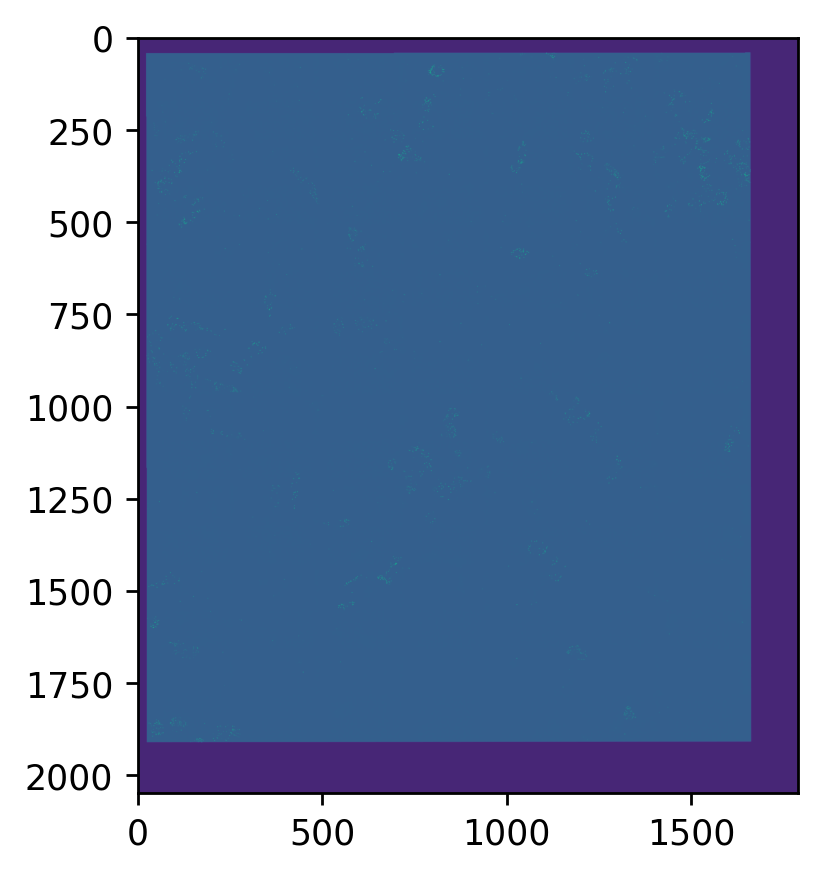

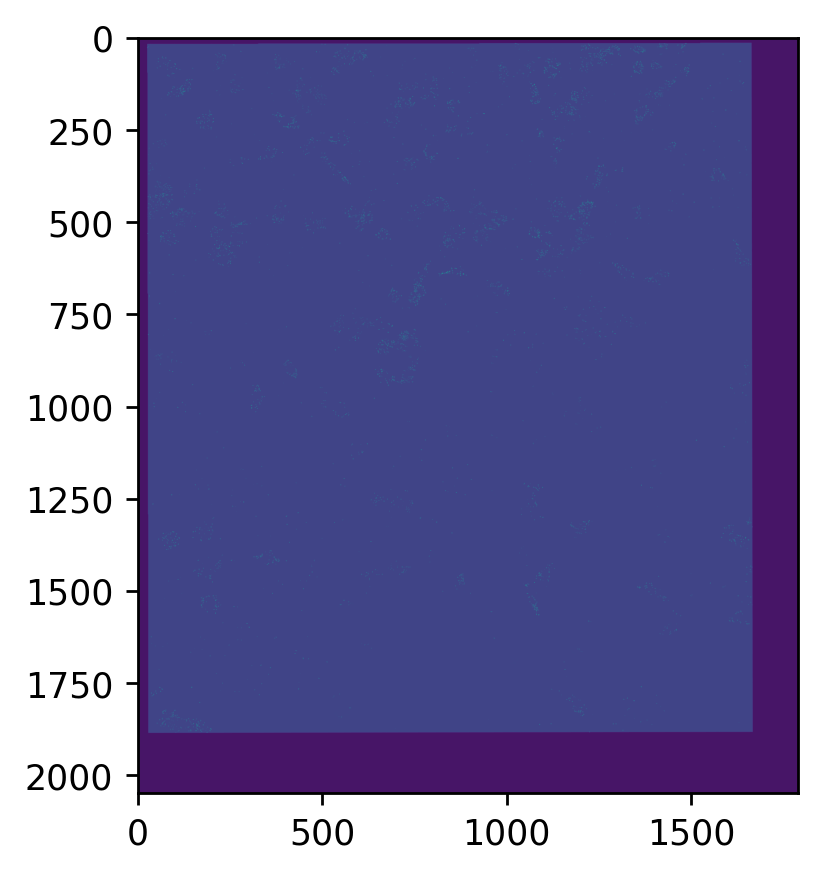

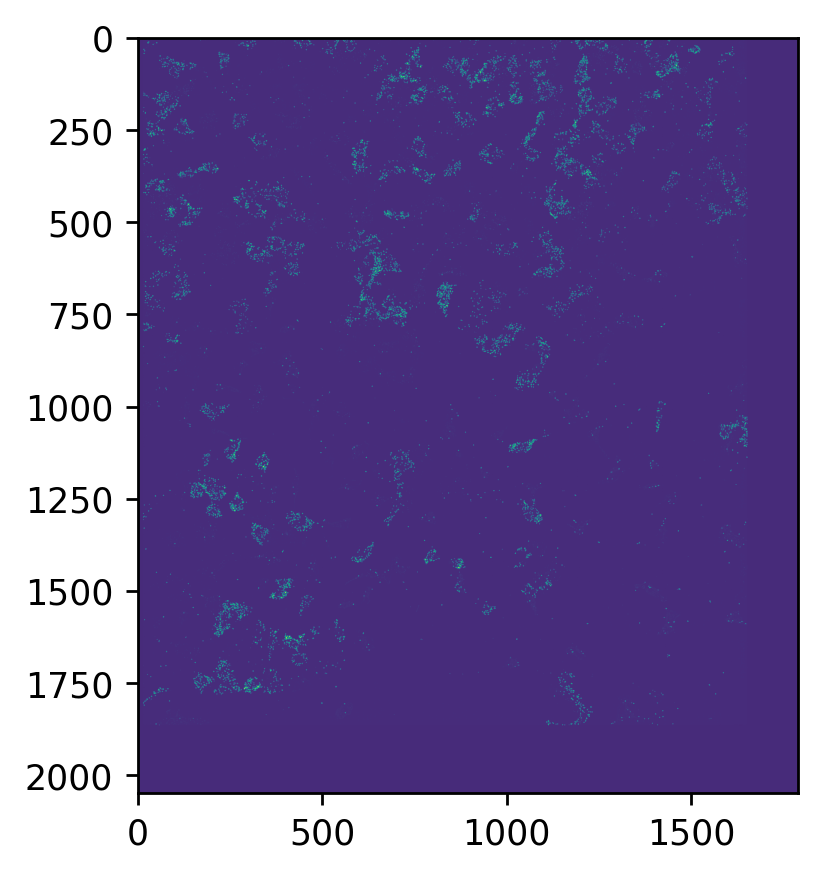

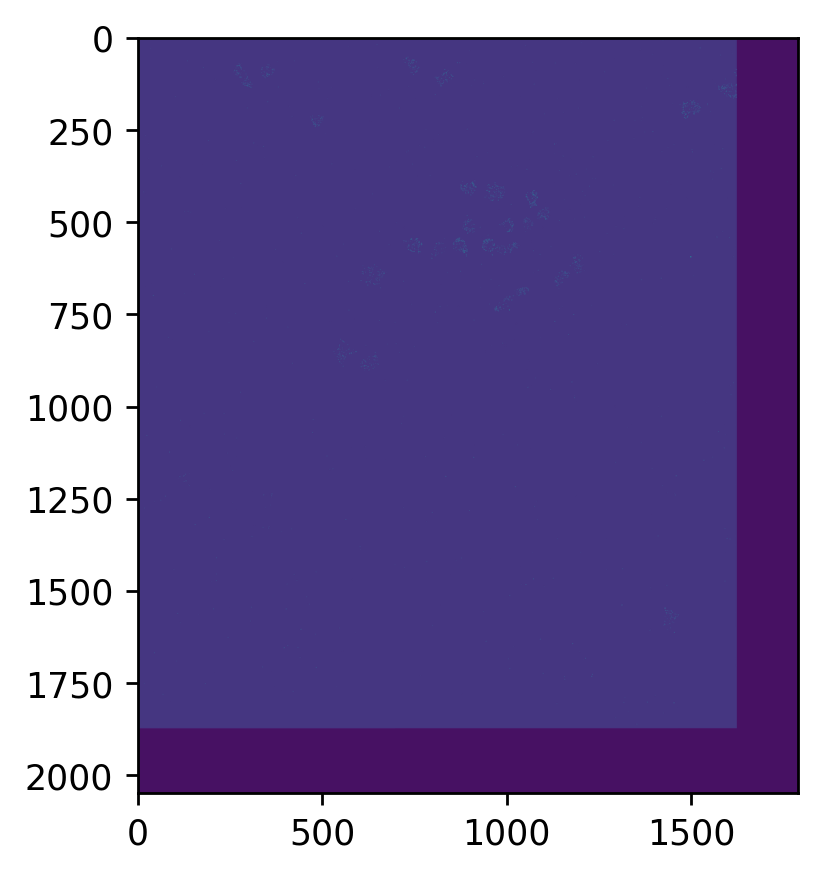

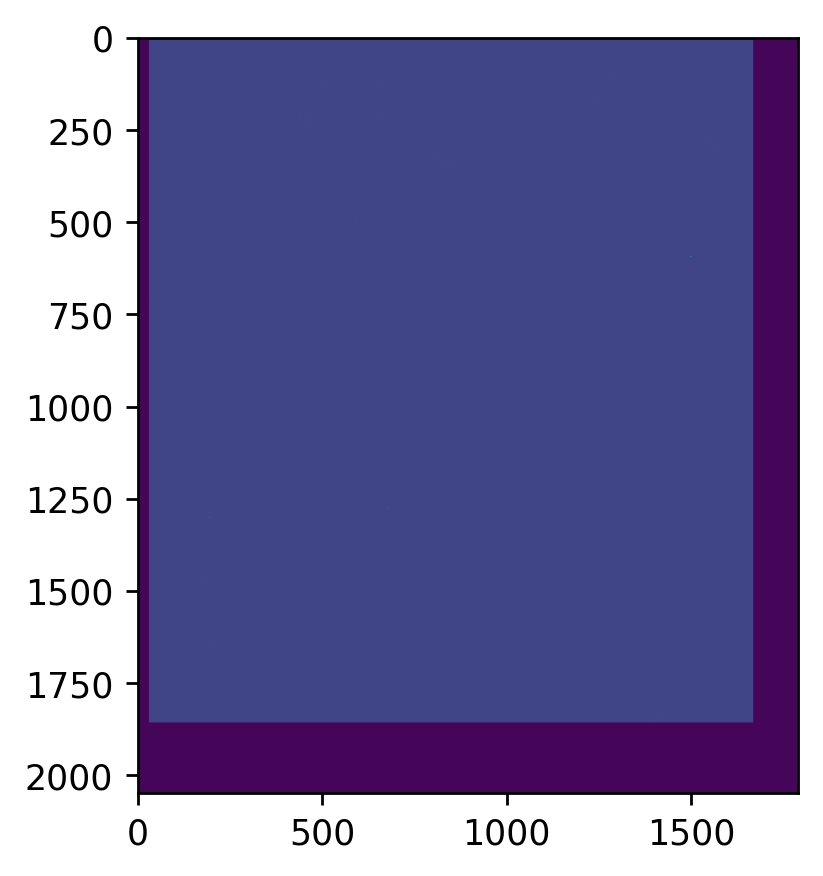

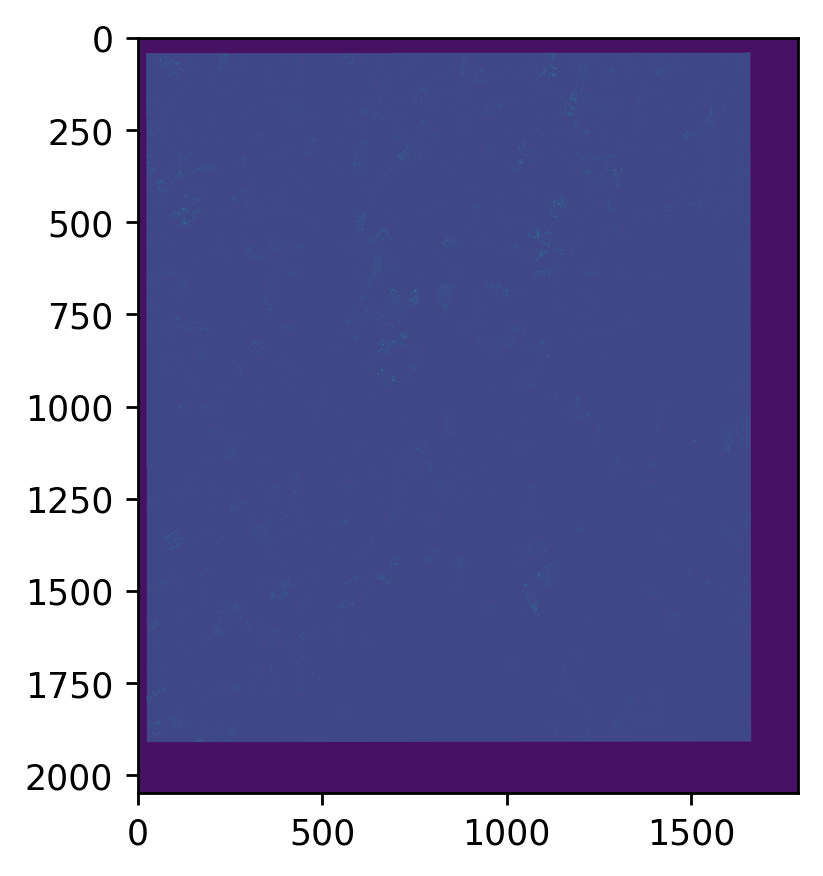

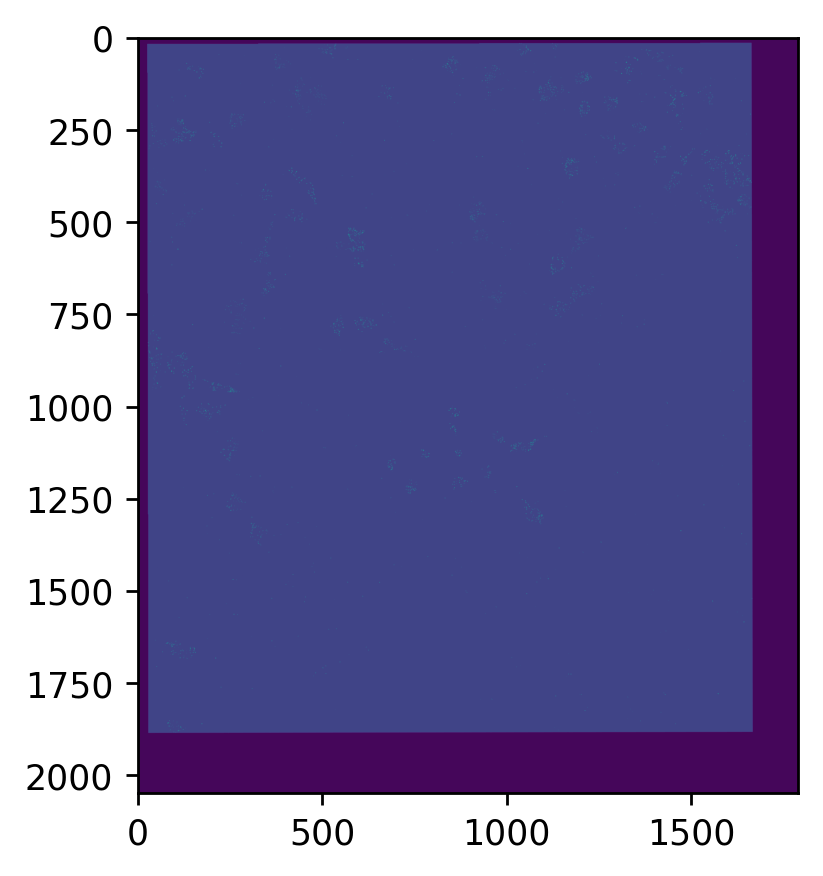

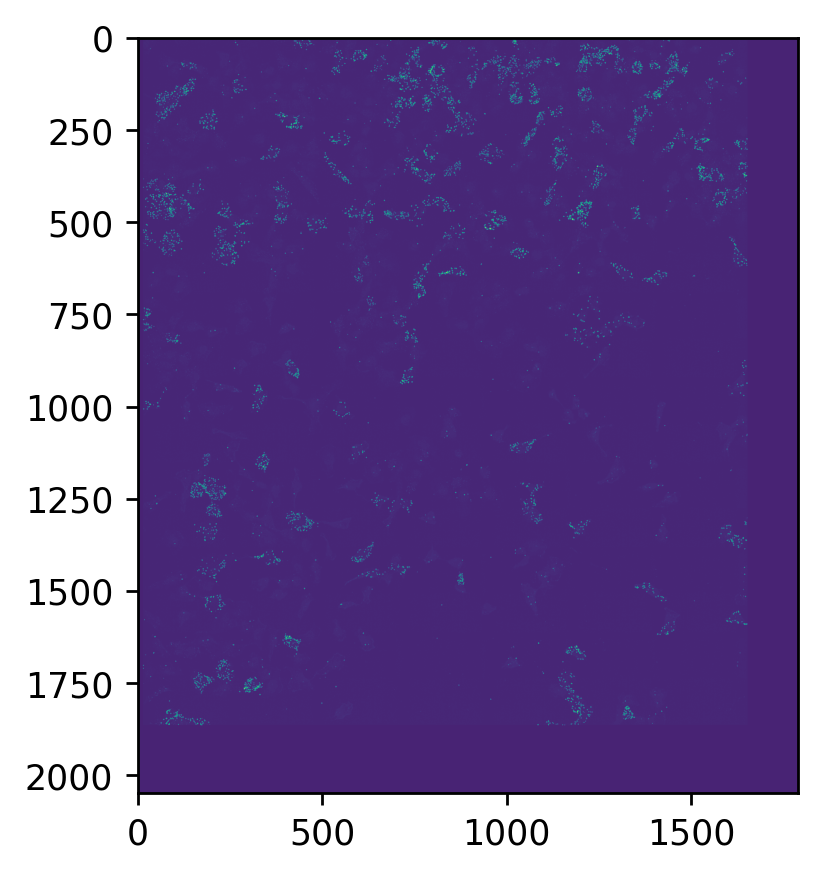

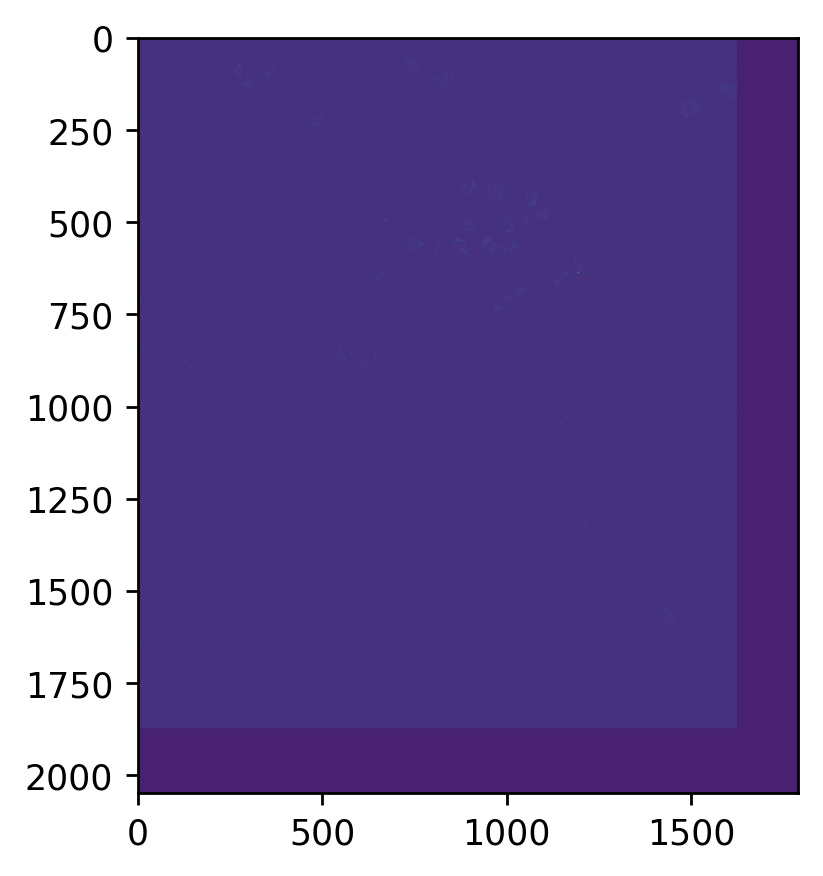

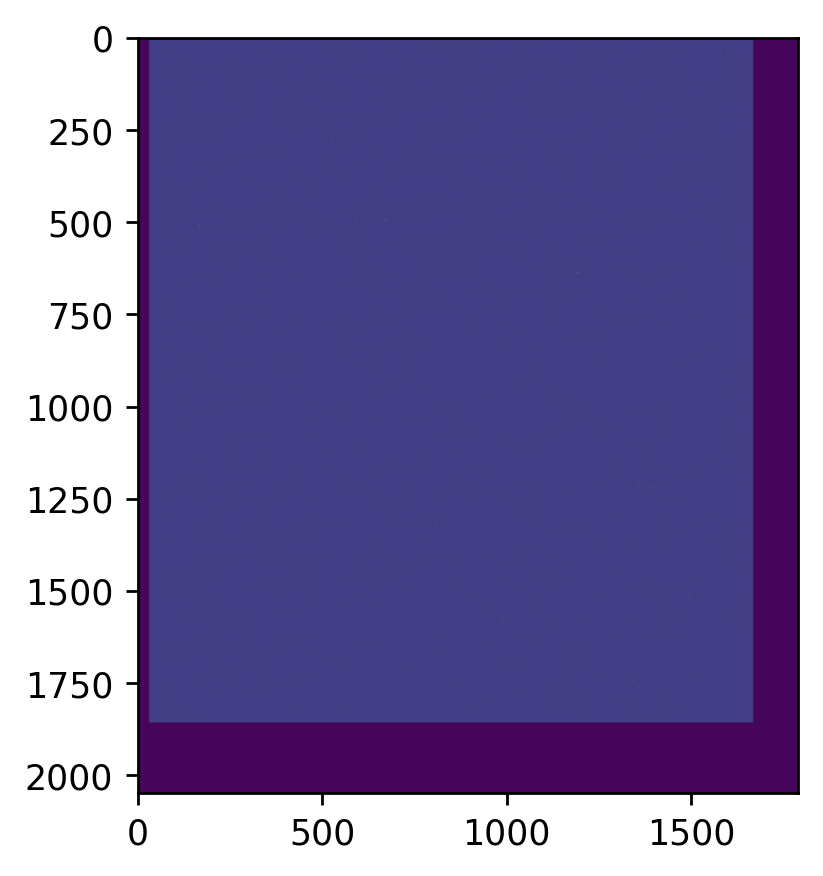

In [14]:
for i in range(X.shape[0]):
    plt.figure(dpi=250)
    plt.imshow(X[i, 0,])

## Check how many pixels are roughly in one amplicon

(-0.5, 19.5, 19.5, -0.5)

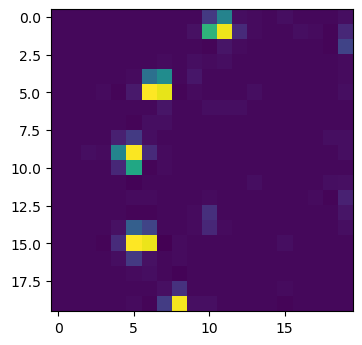

In [3]:
img = tif.imread('./data/registered-updated/amp-ch1-cycle2.tiff')
plt.figure(dpi=100)
plt.imshow(img[80:100, 80:100, 1])
plt.axis('image')
# im.view()

This shows if the windows for local maxima is 3 by 3 pixels, they should be right for catching one amplicon

## Check if there is color bleeding between channels

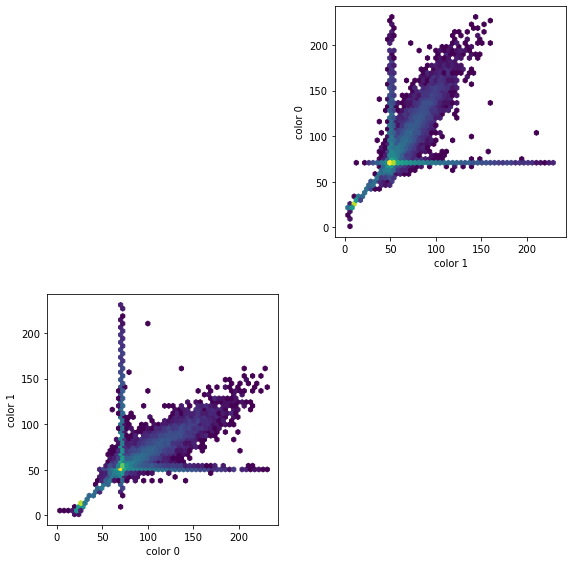

In [15]:
# Plot a graph between every two channels
with bardensr.plotting.AnimAcross(columns=n_channels) as a:
    for c in range(n_channels):
        for d in range(n_channels):
            ~a
            if c!=d:
                bardensr.preprocessing.colorbleed_plot(X[0,d], X[0,c])
                plt.xlabel(f'color {d}')
                plt.ylabel(f'color {c}')
            else:
                plt.axis('off')

## Visualize images

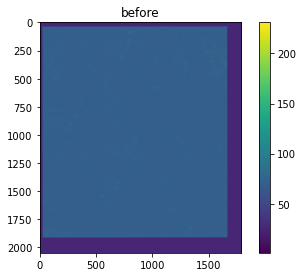

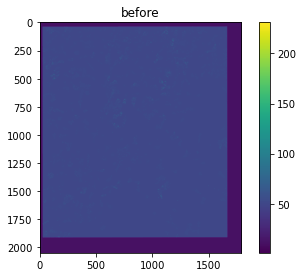

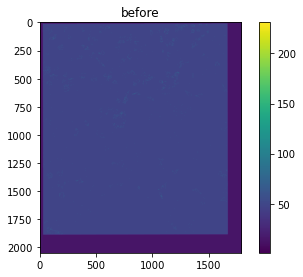

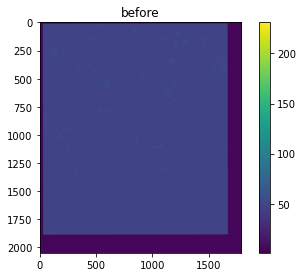

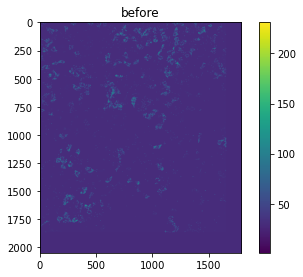

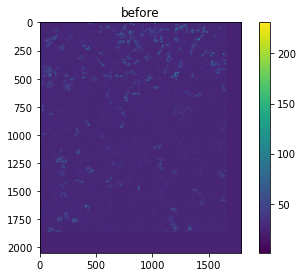

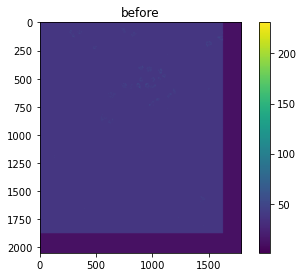

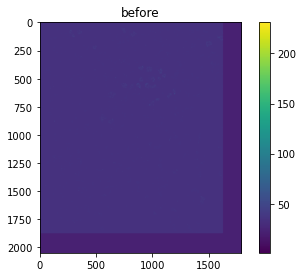

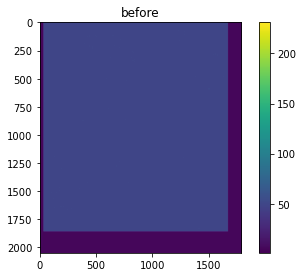

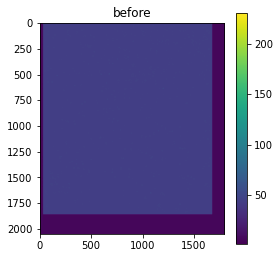

In [24]:
with bardensr.plotting.AnimAcross() as a:
    for i in range(n_cycles):
        for j in range(n_channels):
            plt.figure()
            
            a('before')
            a.cb(plt.imshow(X[i, j, 0]))

## Remove border artifact and get X only within the range of the slide - segmentation images must be set to the same range when overlaying

<Figure size 1800x1200 with 0 Axes>

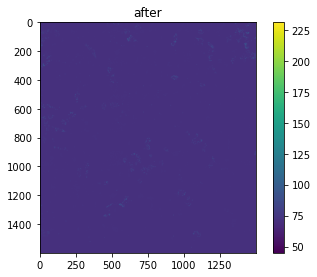

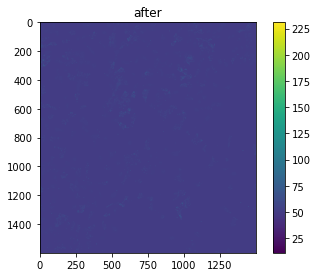

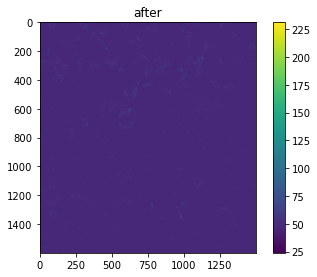

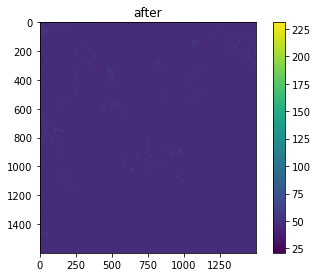

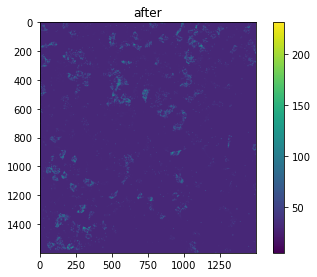

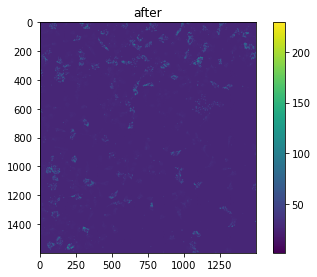

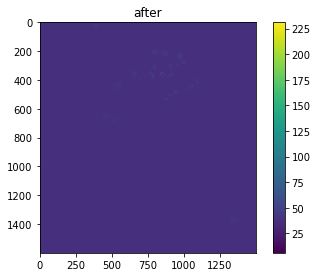

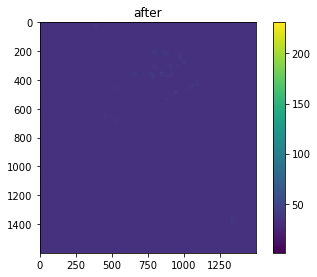

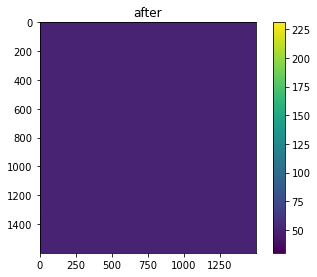

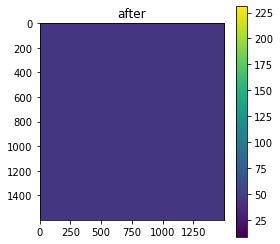

In [6]:
up = 200
down = 1800
left = 100
right = 1600

Xcenter = X[:, :, :, up:down, left:right] # range is selected based on observation of images

plt.figure(dpi=300)
with bardensr.plotting.AnimAcross() as a:
    for i in range(n_cycles):
        for j in range(n_channels):
            plt.figure()
            
            a('after')
            a.cb(plt.imshow(Xcenter[i, j, 0]))

# Codebook

In [7]:
# !! currently the first value shows nan and hard code it to be 1; needs a better fix

csv = np.genfromtxt('./data/CRISPRmap_pilot_codebook_default.csv', filling_values=1, dtype=np.int, delimiter=",")
csv

array([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0]])

In [8]:
csv.shape

(10, 10)

In [9]:
codebook = csv.reshape((10, 2, 5)).T.astype(bool)
codebook

array([[[ True, False, False, False, False, False, False,  True, False,
         False],
        [ True, False, False, False, False,  True,  True, False, False,
         False]],

       [[False, False,  True, False, False,  True, False, False, False,
          True],
        [False, False,  True, False, False, False, False,  True,  True,
         False]],

       [[False, False, False, False,  True, False,  True, False,  True,
         False],
        [False, False, False, False,  True, False, False, False, False,
          True]],

       [[False,  True, False, False, False, False, False, False, False,
         False],
        [False,  True, False, False, False, False, False, False, False,
         False]],

       [[False, False, False,  True, False, False, False, False, False,
         False],
        [False, False, False,  True, False, False, False, False, False,
         False]]])

In [10]:
codebook.shape

(5, 2, 10)

## Background subtraction
Xflat is of the shape (rounds*channels, coordinates)

In [11]:
Xcenter.shape

(5, 2, 1, 1600, 1500)

In [12]:
Xsub = Xcenter.reshape((n_cycles * n_channels,) + Xcenter.shape[-3:]) # initialize Xsub by a fatterned X
codeflat = codebook.reshape((n_cycles*n_channels, -1)) # make sure the codebook are in exactly the same order
Xsub = bardensr.preprocessing.background_subtraction(Xsub,[0,10,10])

In [13]:
Xsub.shape

(10, 1, 1600, 1500)

In [18]:
codeflat

array([[ True, False, False, False, False, False, False,  True, False,
        False],
       [ True, False, False, False, False,  True,  True, False, False,
        False],
       [False, False,  True, False, False,  True, False, False, False,
         True],
       [False, False,  True, False, False, False, False,  True,  True,
        False],
       [False, False, False, False,  True, False,  True, False,  True,
        False],
       [False, False, False, False,  True, False, False, False, False,
         True],
       [False,  True, False, False, False, False, False, False, False,
        False],
       [False,  True, False, False, False, False, False, False, False,
        False],
       [False, False, False,  True, False, False, False, False, False,
        False],
       [False, False, False,  True, False, False, False, False, False,
        False]])

## Contrast enhancement
Don't use contrast enhancement because it stretches the values close to 0 and adds background noise.

<!-- ## Contrast enhancement
This also brings the signal strength from different cycles to comparable levels. -->

In [43]:
# Xce = Xsub
# for i in range(Xsub.shape[0]):
#     ce = PIL.ImageEnhance.Contrast(PIL.Image.fromarray(np.uint8(255*Xsub[i, 0])))
#     Xce[i,] = ce.enhance(1.5)

In [23]:
# Xce.shape

(10, 1, 1600, 1500)

In [26]:
# # Before and after (partial region)
# with bardensr.plotting.AnimAcross() as a:
#     for i in range(n_cycles):
#         plt.figure()

#         a('before')
#         a.cb(plt.imshow(Xsub[i, 0, 200:300, 200:300]))

#         a('after')
#         a.cb(plt.imshow(Xce[i, 0, 200:300, 200:300]))

In [45]:
# # Before and after (whole images)
# with bardensr.plotting.AnimAcross() as a:
#     for i in range(n_cycles):
#         plt.figure()

#         a('before')
#         a.cb(plt.imshow(Xsub[i, 0]))

#         a('after')
#         a.cb(plt.imshow(Xce[i, 0]))

## Fine registration
This registration is problematic because it changes the number of pixels in an image and will not match the image segmentation.

<!-- ## Fine registration
Data have gone through coarse registration
Don't use fine registration because it changes the number of pixels of the whole images -->

In [90]:
# corrections = bardensr.registration.find_translations_using_model(Xce, codeflat, use_tqdm_notebook=True)

In [91]:
# # !! Caution: rewrite Xce here outside Xce's original cell

# Xce, newt = bardensr.registration.apply_translations(Xce, corrections)

In [92]:
# Xce.shape

## Normalization

In [14]:
Xnorm = bardensr.preprocessing.minmax(Xsub)

## Distribution

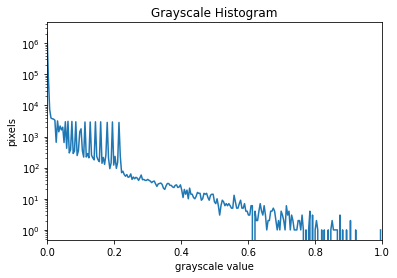

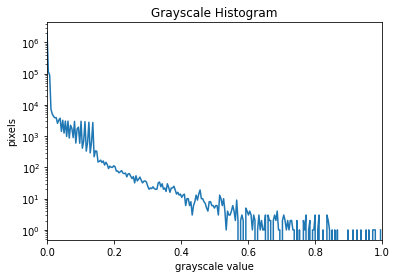

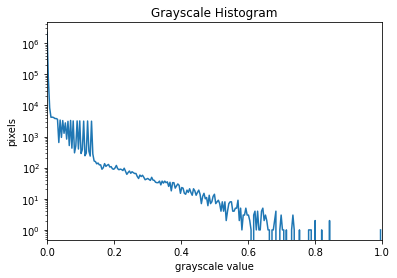

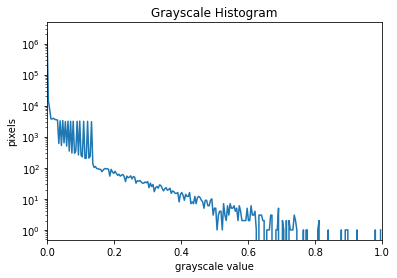

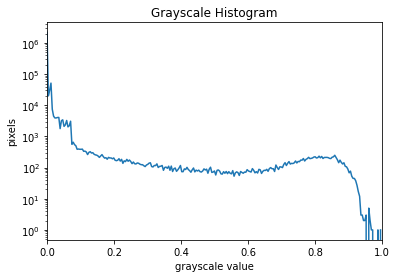

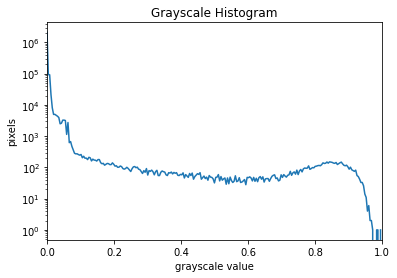

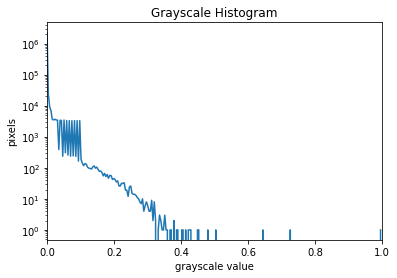

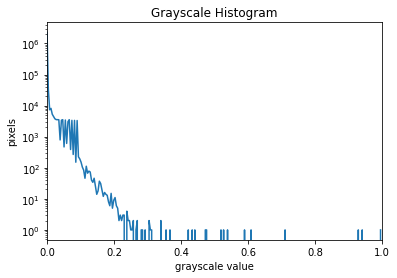

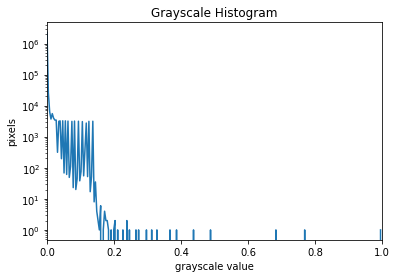

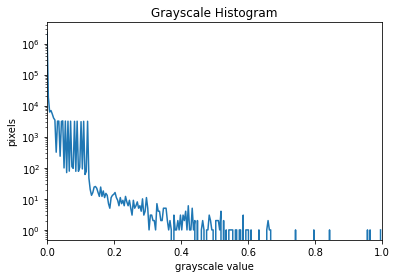

In [15]:
# create the histogram
for i in range(Xnorm.shape[0]):
    histogram, bin_edges = np.histogram(Xnorm[i, 0], bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")

    plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

    plt.xlim([0.0, 1.0])  # <- named arguments do not work here
    plt.show()

## Thresholding
Upper outliers above upper bound: set to upper bound

Lower outliers (ghost effect between cycles) below lower bound: set to 0

In [16]:
Xnorm.shape

(10, 1, 1600, 1500)

In [17]:
Xnorm[0, 0,].shape

(1600, 1500)

In [53]:
upper = 0.9
lower = [0.2, 0.15, 0.15, 0.15, 0.1, 0.1, 0.1, 0.1, 0.13, 0.13]
Xthresh = Xnorm
for i in range(Xthresh.shape[0]):
    single = Xthresh[i, 0,]
    single[single < lower[i]] = 0
    single[single > upper] = upper
    Xthresh[i, 0] = single

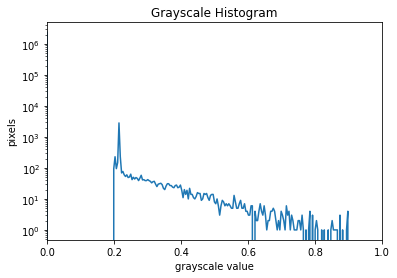

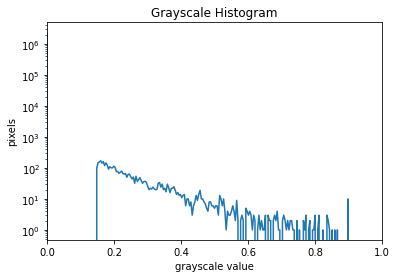

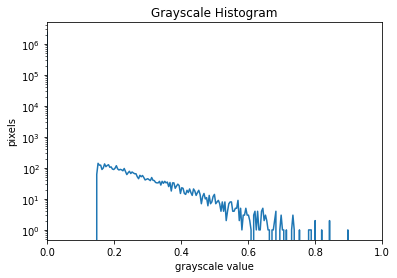

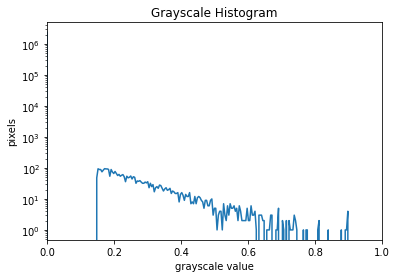

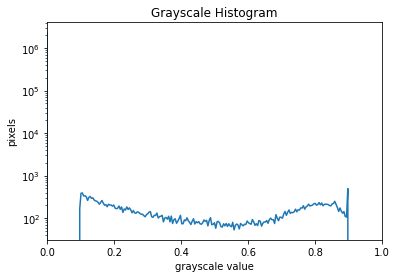

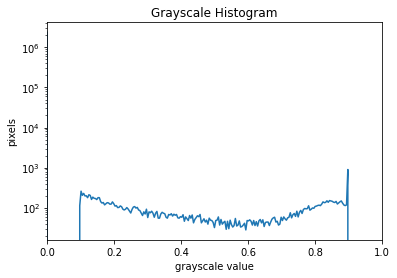

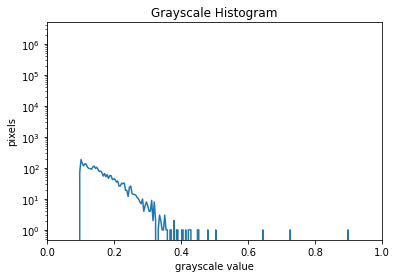

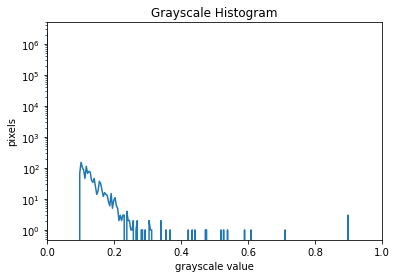

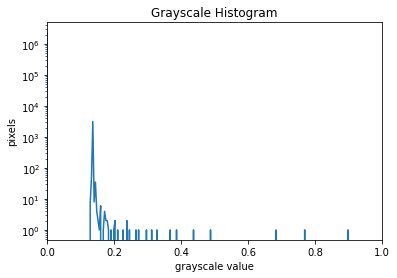

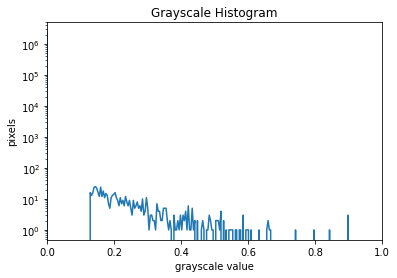

In [54]:
for i in range(Xthresh.shape[0]):
    histogram, bin_edges = np.histogram(Xthresh[i, 0], bins=256, range=(0, 1))

    # configure and draw the histogram figure
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")

    plt.semilogy(bin_edges[0:-1], histogram)  # <- or here

    plt.xlim([0.0, 1.0])  # <- named arguments do not work here
    plt.show()

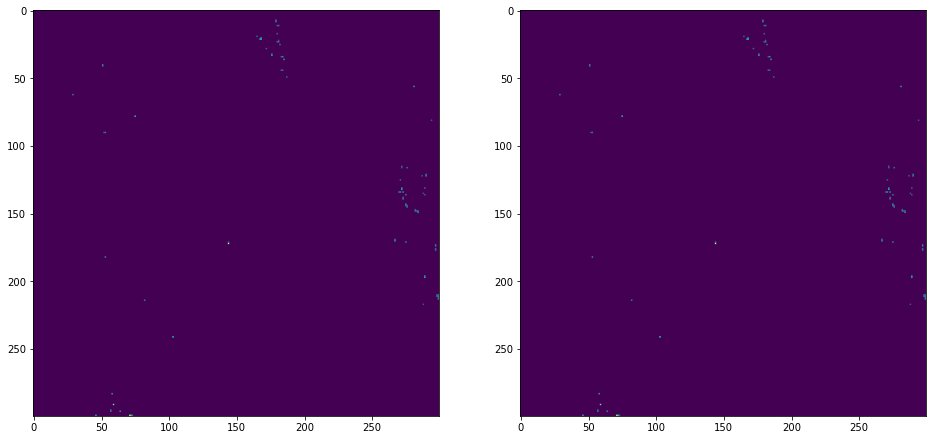

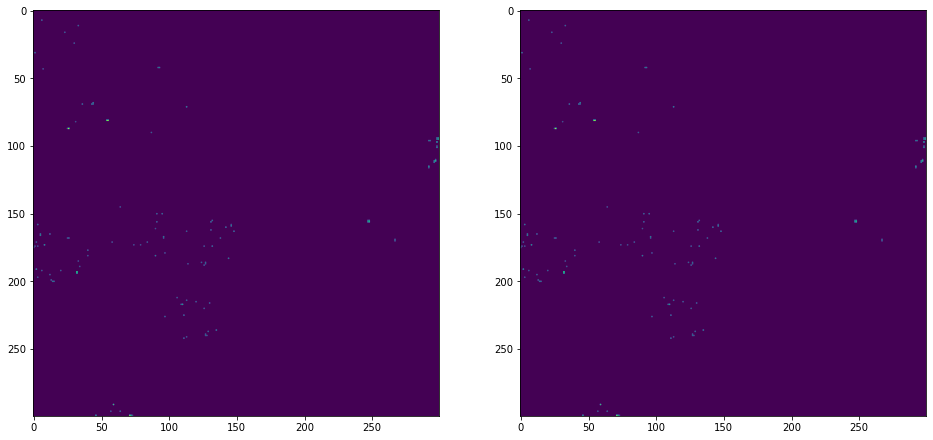

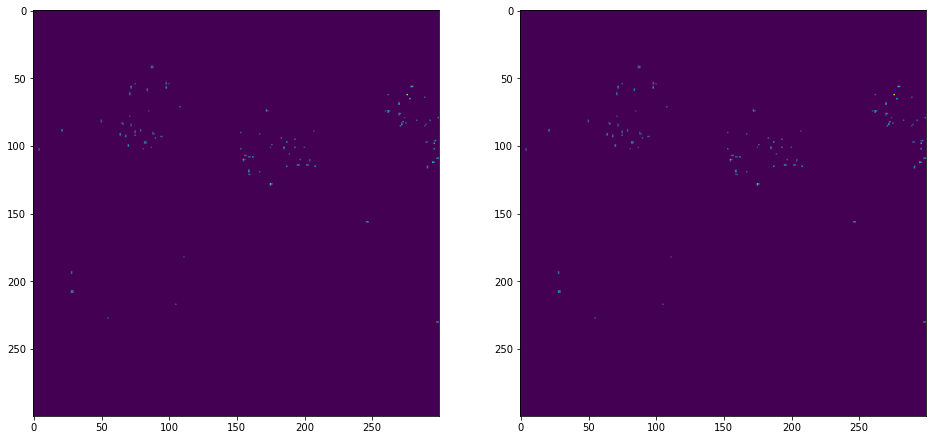

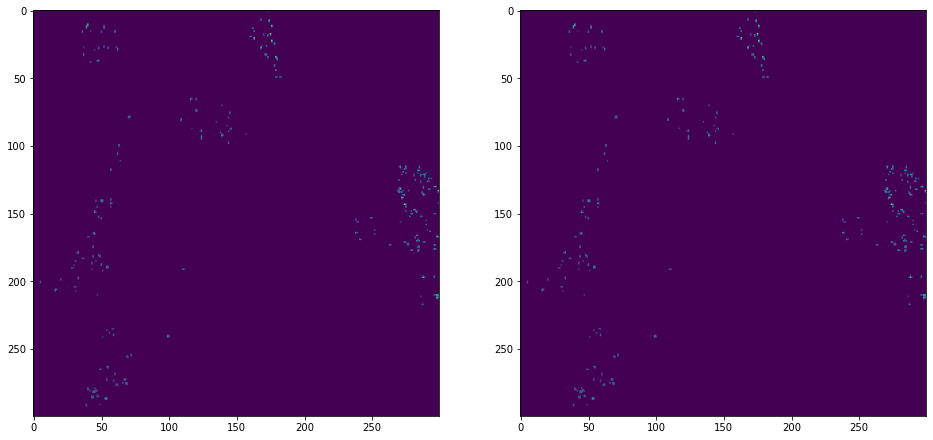

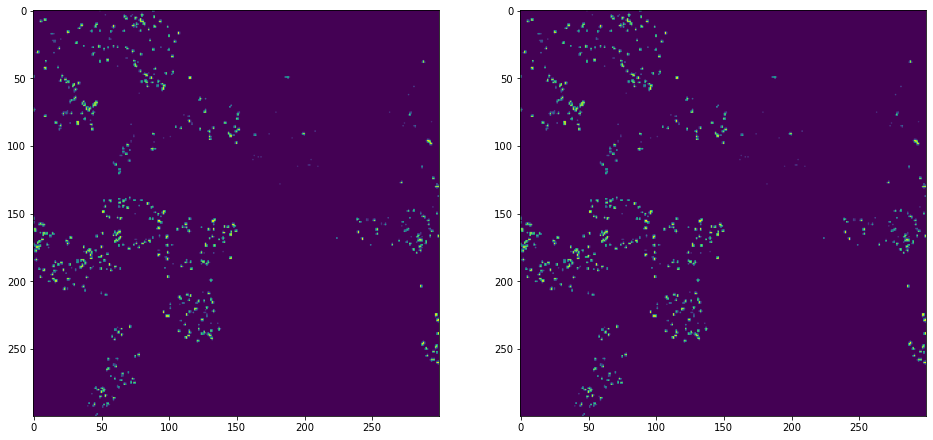

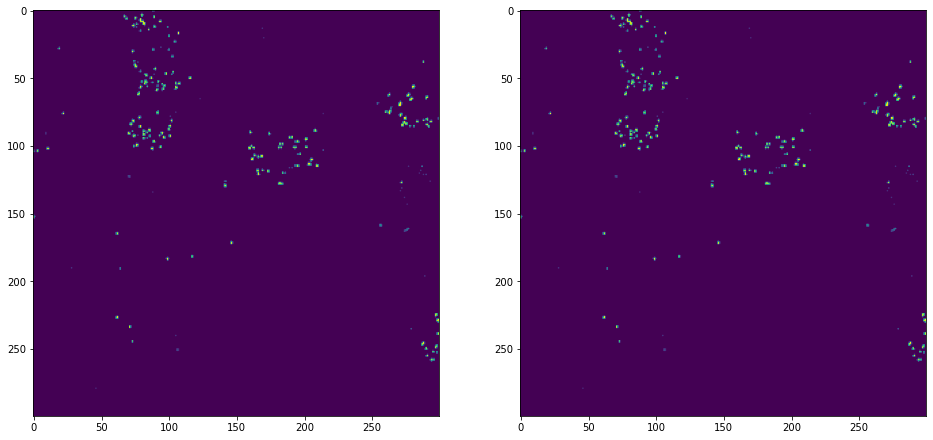

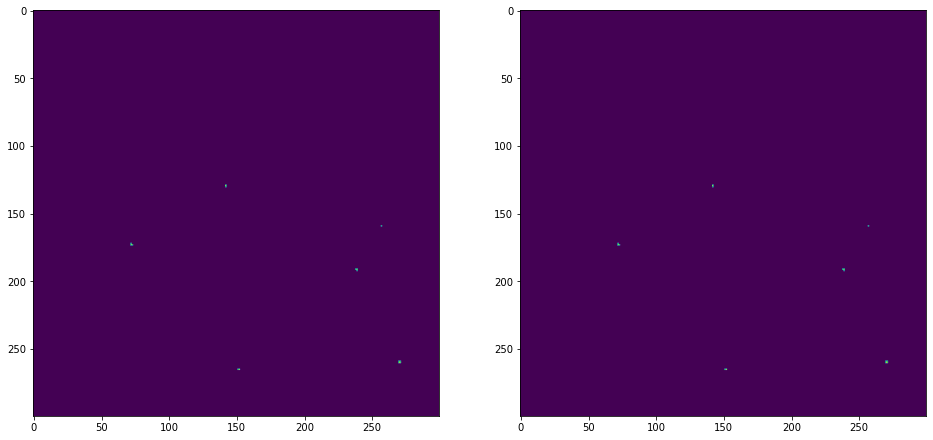

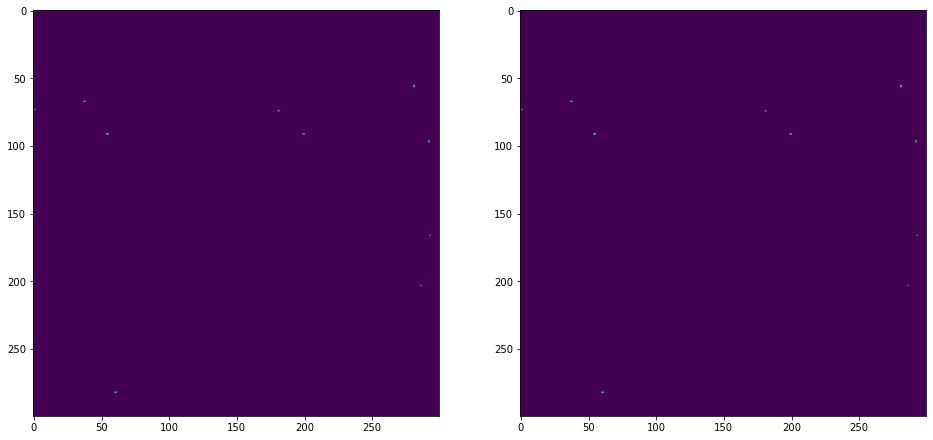

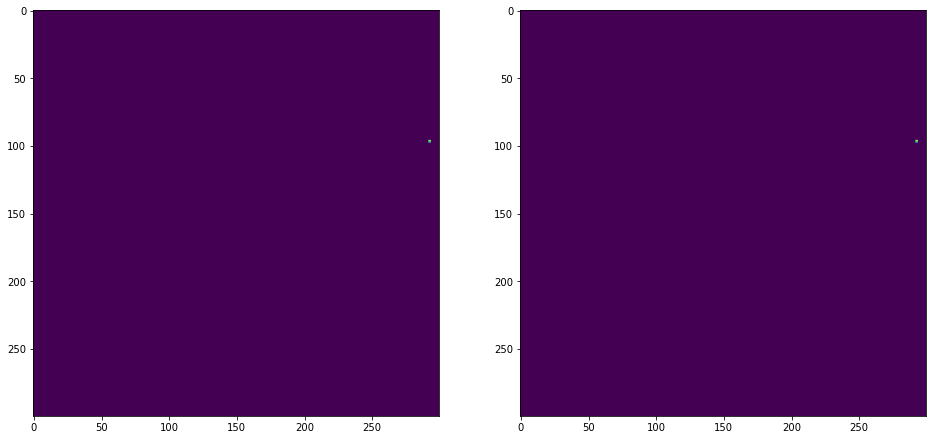

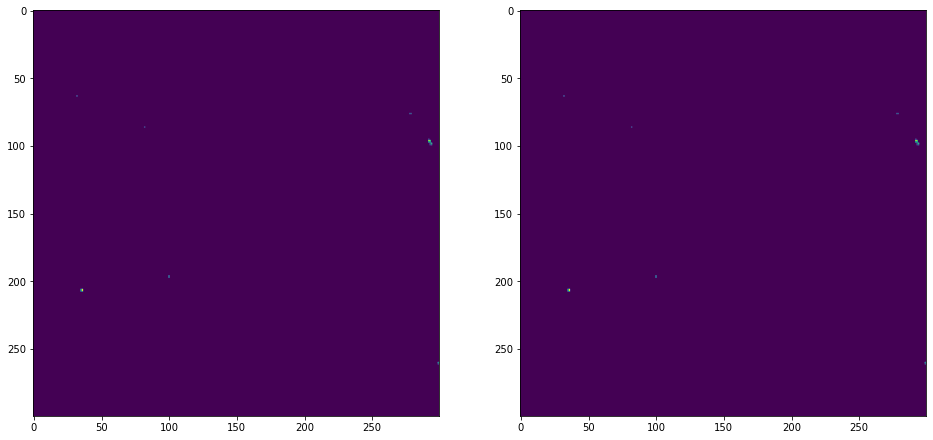

In [63]:
# Before and after (partial region)
# with bardensr.plotting.AnimAcross() as a:
for i in range(n_cycles*n_channels):
    plt.figure(figsize=(16, 15))
    plt.subplot(1, 2, 1)
#     a('before')
    plt.imshow(Xnorm[i, 0, 200:500, 200:500])
    plt.subplot(1, 2, 2)
#     a('after')
    plt.imshow(Xthresh[i, 0, 200:500, 200:500])

# Correlation


**Set a different window_size for local maxima first**

In [66]:
# Set a different window_size for local maxima first

# evidence_tensor=bardensr.spot_calling.estimate_density_singleshot(Xnorm, codeflat, noisefloor=.05)  # original noisefloor
evidence_tensor=bardensr.spot_calling.estimate_density_singleshot(Xthresh, codeflat, noisefloor=0.01) # set noisefloor to 0 because already thresholded

In [67]:
thresh=.72  # original threshold
result_corr = bardensr.spot_calling.find_peaks(evidence_tensor,thresh)
result_corr

,m0,m1,m2,j
0,0,1,1451,0
1,0,1,1455,0
2,0,2,506,0
3,0,4,551,0
4,0,4,1460,0
...,...,...,...,...
4634,0,1318,1323,9
4635,0,1336,450,9
4636,0,1457,1092,9
4637,0,1581,229,9


In [68]:
result_corr.to_csv('crisprmap20210506_layer1out0123_result_corr_thresh72_preprocessed.csv', index=False)